# Artificial Neural Networks to Predict Winners and Upsets

In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [48]:
kp = pd.read_csv("/content/kenpom_tournament_clean.csv")
kp

,Unnamed: 0,TeamName,Season,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,...,seed,BY.YEAR.NO,BY.ROUND.NO,TEAM.NO,SEED,ROUND,CURRENT.ROUND,SCORE,Win,Upset
0,1,Memphis,2008,70.5062,59.0,67.7113,63.0,112.778,18.0,114.695,...,1.0,1,1,37,1,2,2,68,False,0
1,2,Kansas,2008,68.8789,106.0,66.8546,88.0,117.530,1.0,121.433,...,1.0,2,2,43,1,1,2,75,True,0
2,3,UCLA,2008,65.0976,246.0,63.1761,220.0,113.555,10.0,118.735,...,1.0,3,31,13,1,4,4,63,False,0
3,4,Memphis,2008,70.5062,59.0,67.7113,63.0,112.778,18.0,114.695,...,1.0,4,32,37,1,2,4,78,True,0
4,5,Kansas,2008,68.8789,106.0,66.8546,88.0,117.530,1.0,121.433,...,1.0,5,33,43,1,1,4,84,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1884,San Diego St.,2023,66.5126,254.0,66.0090,252.0,106.670,99.0,111.929,...,5.0,1884,1884,961,5,2,64,63,True,0
1884,1885,West Virginia,2023,69.8826,84.0,68.8537,104.0,108.969,58.0,117.144,...,9.0,1885,1885,945,9,64,64,65,False,0
1885,1886,Maryland,2023,64.5455,335.0,64.6104,312.0,109.025,56.0,114.136,...,8.0,1886,1886,979,8,32,64,67,True,0
1886,1887,Texas A&M Corpus Chris,2023,70.6680,53.0,69.2572,80.0,109.864,41.0,107.367,...,16.0,1887,1887,955,16,64,64,75,False,0


In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1. Subset the DataFrame
subset_kp = kp[['AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'Win']]

# Avoid using inplace=True to prevent SettingWithCopyWarning
subset_kp = subset_kp.dropna()

# Define your input data (X_train, X_val, X_test)
# Assuming X_train, X_val, and X_test are numpy arrays or pandas DataFrames

# Split the data into train, val, and test sets
train_val_df, test_df = train_test_split(subset_kp, test_size=0.2, random_state=100)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=100)

# Separate the target variable 'Upset' from the features for each set
X_train, y_train = train_df.drop(columns=['Win']), train_df['Win']
X_val, y_val = val_df.drop(columns=['Win']), val_df['Win']
X_test, y_test = test_df.drop(columns=['Win']), test_df['Win']

# Define the normalization layer
normalization_layer = tf.keras.layers.Normalization()

# Calculate the mean and standard deviation of the training data
normalization_layer.adapt(X_train.to_numpy())  # Convert DataFrame to numpy array

# Normalize the data
X_train_normalized = normalization_layer(X_train)
X_val_normalized = normalization_layer(X_val)
X_test_normalized = normalization_layer(X_test)


In [28]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

class MLPBinaryClassifier:
    def __init__(self, params):
        self.params = params
        self.model = self.build_model()
        self.history = None

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(self.params['num_nodes'], input_shape=(self.params['input_shape'],), activation=self.params['activation']))

        for _ in range(self.params['num_hidden_layers']):
            model.add(tf.keras.layers.Dense(self.params['num_nodes'], activation=self.params['activation']))
            if self.params['dropout'] > 0.0:
                model.add(tf.keras.layers.Dropout(self.params['dropout']))
            if self.params['l1_regularization'] > 0.0:
                model.add(tf.keras.layers.Dense(self.params['num_nodes'], activation=self.params['activation'], kernel_regularizer=tf.keras.regularizers.l1(self.params['l1_regularization'])))
            if self.params['l2_regularization'] > 0.0:
                model.add(tf.keras.layers.Dense(self.params['num_nodes'], activation=self.params['activation'], kernel_regularizer=tf.keras.regularizers.l2(self.params['l2_regularization'])))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
        model.compile(optimizer=self.params['optimizer'],
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, x_val, y_val):
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
        self.history = self.model.fit(x_train, y_train, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                                      validation_data=(x_val, y_val), callbacks=[es], verbose=1)

    def report(self, x_train, y_train, x_val, y_val, x_test, y_test):
        if self.history is None:
            raise ValueError("Model has not been trained yet.")

        # Plot training and validation loss
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        # Confusion matrix and classification report
        for name, x, y in [('Training', x_train, y_train), ('Validation', x_val, y_val), ('Test', x_test, y_test)]:
            y_pred_prob = self.model.predict(x)
            y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
            cm = confusion_matrix(y, y_pred)
            plt.imshow(cm, cmap=plt.cm.Blues)
            plt.title(f'{name} Confusion Matrix')
            plt.colorbar()
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()
            print(f'{name} Classification Report:\n', classification_report(y, y_pred))

        # Print accuracies
        train_accuracy = self.model.evaluate(x_train, y_train, verbose=0)[1]
        val_accuracy = self.model.evaluate(x_val, y_val, verbose=0)[1]
        test_accuracy = self.model.evaluate(x_test, y_test, verbose=0)[1]
        print(f'Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}')

        # Plot ROC curve
        self.plot_roc_curve(x_test, y_test)

        # Save the trained model
        serialized_data = {
            'params': self.params
        }
        serialized_data['params'].pop('optimizer', None)  # Exclude non-serializable optimizer attribute
        json_file_path = 'trained_model.json'
        with open(json_file_path, 'w') as json_file:
            json.dump(serialized_data, json_file)

        print("Model was saved successfully.")

    def plot_roc_curve(self, x_test, y_test):
        y_pred_proba = self.model.predict(x_test).ravel()
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


Using the classifier object

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5312 - loss: 37.5035 - val_accuracy: 0.5767 - val_loss: 31.5929
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6473 - loss: 29.8450 - val_accuracy: 0.6000 - val_loss: 24.8597
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6574 - loss: 23.2846 - val_accuracy: 0.5767 - val_loss: 18.9118
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6325 - loss: 17.5719 - val_accuracy: 0.6400 - val_loss: 13.8346
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6732 - loss: 12.6996 - val_accuracy: 0.6367 - val_loss: 9.6204
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6506 - loss: 8.7368 - val_accuracy: 0.5833 - val_loss: 6.4059
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6423 - loss: 5.7674 - val_accuracy: 0.6300 - val_loss: 4.0987
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6587 - loss: 3.6650 - val_accuracy: 

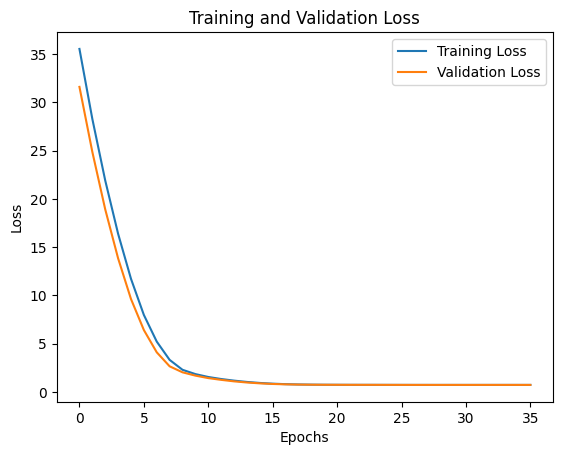

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


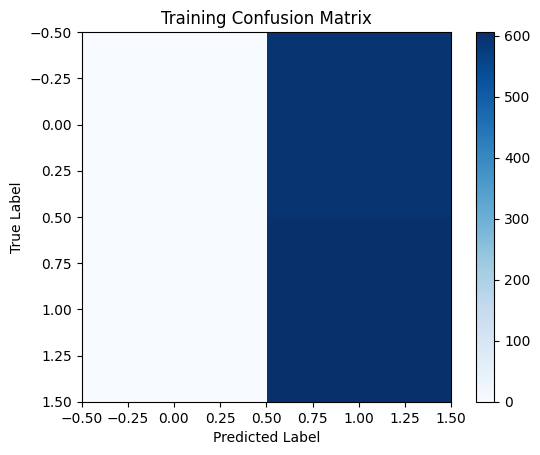

Training Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       593
        True       0.51      1.00      0.67       606

    accuracy                           0.51      1199
   macro avg       0.25      0.50      0.34      1199
weighted avg       0.26      0.51      0.34      1199

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


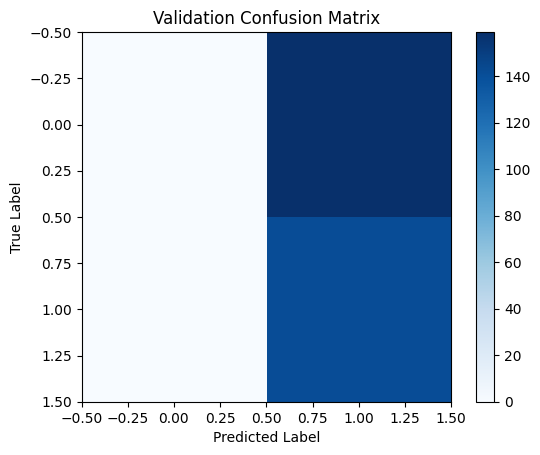

Validation Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       159
        True       0.47      1.00      0.64       141

    accuracy                           0.47       300
   macro avg       0.23      0.50      0.32       300
weighted avg       0.22      0.47      0.30       300

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


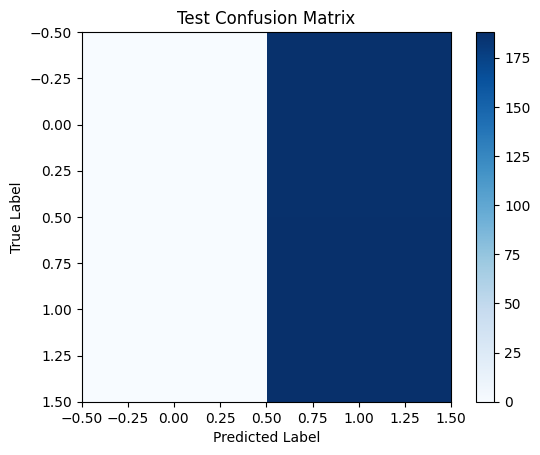

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       187
        True       0.50      1.00      0.67       188

    accuracy                           0.50       375
   macro avg       0.25      0.50      0.33       375
weighted avg       0.25      0.50      0.33       375

Training Accuracy: 0.5054
Validation Accuracy: 0.4700
Test Accuracy: 0.5013
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


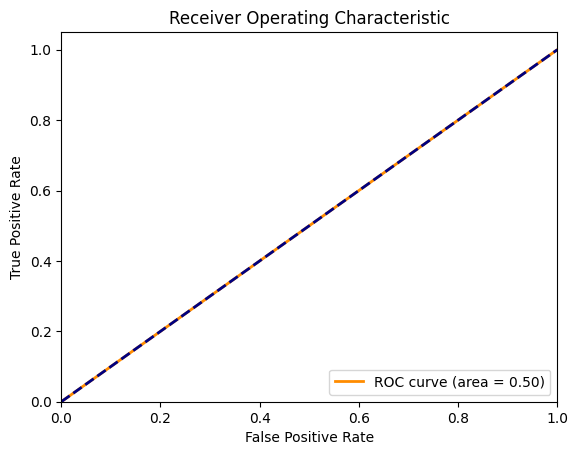

Model was saved successfully.


In [31]:
# Example usage
params = {
    'num_nodes': 28,
    'input_shape': 4,  # Assuming 4 features
    'activation': 'relu',
    'dropout': 0,
    'l1_regularization': 0.1,
    'l2_regularization': 0,
    'optimizer': 'adam',
    'epochs': 100,
    'batch_size': 32,
    'num_hidden_layers': 3  # Number of hidden layers
}

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are defined
classifier = MLPBinaryClassifier(params)
classifier.train(X_train, y_train, X_val, y_val)
classifier.report(X_train, y_train, X_val, y_val, X_test, y_test)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Define the model with regularization, dropout, and Adam optimizer
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Adjust dropout rate
    Dense(1, activation='sigmoid')
])

# Clip gradients
optimizer = Adamax()

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Increase batch size for better stability
batch_size = 64

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5100 - loss: 19.8836
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4802 - loss: 8.5436   
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4812 - loss: 6.0235 
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4450 - loss: 6.2870 
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4855 - loss: 5.4337 
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4794 - loss: 5.7875 
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4966 - loss: 5.5520 
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4896 - loss: 5.0034 
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5335 - loss: 4.5049  
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4953 - loss: 4.6977 


# Logistic Regression

In [41]:
# 1. Subset the DataFrame
subset_kp = kp[['AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'seed', 'Upset']]
subset_kp.dropna(inplace=True)

# 2. Split the data into train, val, and test sets
train_val_df, test_df = train_test_split(subset_kp, test_size=0.2, random_state=100)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=100)

# 3. Separate the target variable 'Win' from the features for each set
X_train, y_train = train_df.drop(columns=['Upset']), train_df['Upset']
X_val, y_val = val_df.drop(columns=['Upset']), val_df['Upset']
X_test, y_test = test_df.drop(columns=['Upset']), test_df['Upset']

from sklearn.preprocessing import StandardScaler

# 1. Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<ipython-input-41-a8b7c628df2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_kp.dropna(inplace=True)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a logistic regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = logistic_model.predict(X_val)

# Evaluate the model
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Classification report
print('Validation Classification Report:\n', classification_report(y_val, y_pred_val))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
print('Validation Confusion Matrix:\n', cm)

Validation Accuracy: 0.8467
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       255
           1       0.00      0.00      0.00        45

    accuracy                           0.85       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.72      0.85      0.78       300

Validation Confusion Matrix:
 [[254   1]
 [ 45   0]]


# SVM

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
}

# Create an SVM classifier
svm_classifier = SVC()

# Grid search
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Predict on the validation set using the best model
best_svm_classifier = grid_search.best_estimator_
y_pred_val_svm = best_svm_classifier.predict(X_val)

# Evaluate the classifier on the validation set
val_accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
print(f'Validation Accuracy (SVM): {val_accuracy_svm:.4f}')

# Predict on the test set using the best model
y_pred_test_svm = best_svm_classifier.predict(X_test)

# Evaluate the classifier on the test set
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f'Test Accuracy (SVM): {test_accuracy_svm:.4f}')


Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Validation Accuracy (SVM): 0.8500
Test Accuracy (SVM): 0.8667
